# Libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import random
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import requests
import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('main_task.csv')
cities = pd.read_csv('all_cities.csv', index_col=0)
cities.set_index('Name', inplace=True)
capitals = pd.read_csv('capitals.csv', index_col=0)
pd.options.display.max_colwidth = 150
g_words = pd.read_csv('positive-words.txt', header=None)
b_words = pd.read_csv('negative-words.csv', header=None)
life = pd.read_csv('level_life.csv')
life.set_index('Country', inplace=True)

display(data.info(),
        data.sample())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
30025,id_425,Oporto,NaN,426.0,4.5,NaN,33.0,"[['Very good price / quality ratio', 'One of the best sushi restaurants in Europ...'], ['02/03/2018', '05/31/2017']]",/Restaurant_Review-g189180-d12438510-Reviews-Sabores_do_Sushi-Porto_Porto_District_Northern_Portugal.html,d12438510


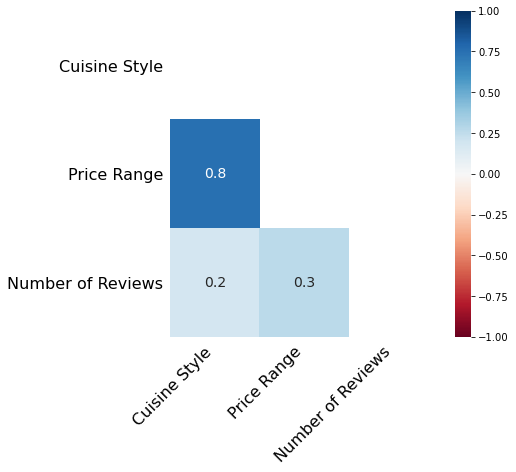

In [3]:
msno.heatmap(data, figsize=(6, 6))

На графике видна существенна взаимосвязь пропущенный значений 'cuisine' и 'price' 

In [4]:
# более того, все пропущенные значения в 'cuisine' также не существуют и в 'price'
data[data['Cuisine Style'].astype(
    str) == 'nan']['Price Range'].isna().value_counts()

True    9283
Name: Price Range, dtype: int64

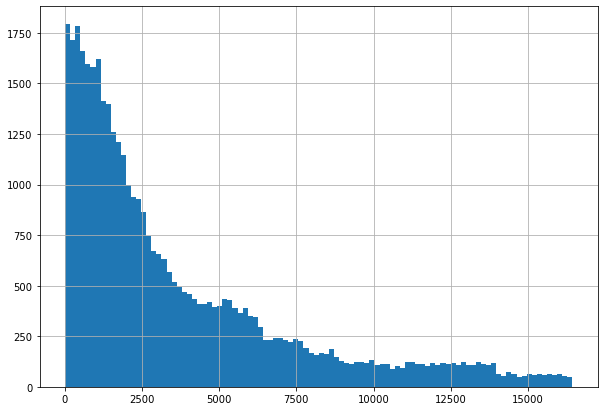

In [5]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе

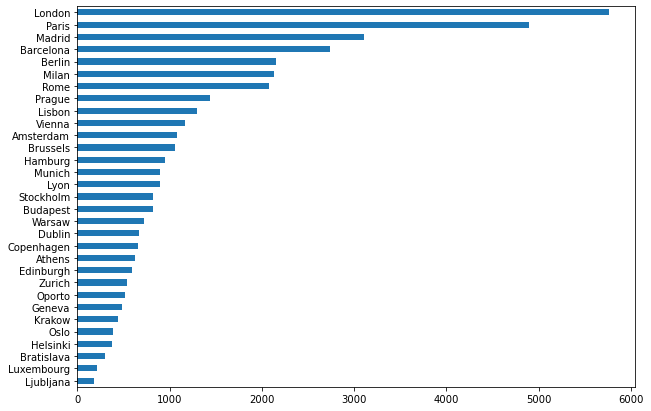

In [6]:
data['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе

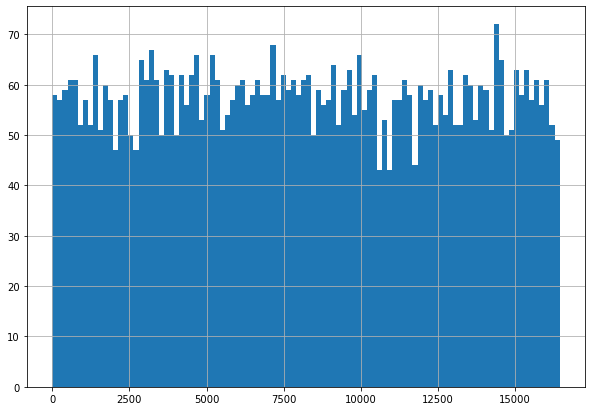

In [7]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

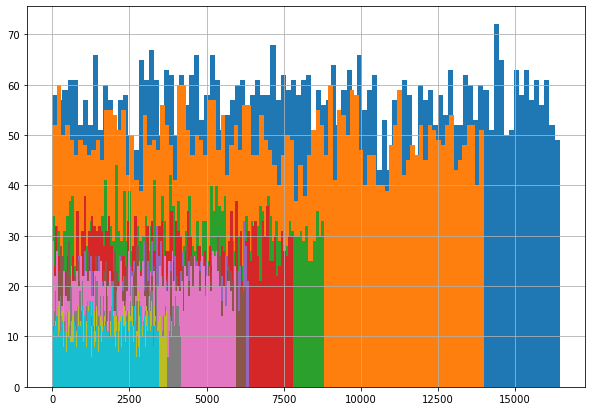

In [8]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

# Посмотрим распределение целевой переменной

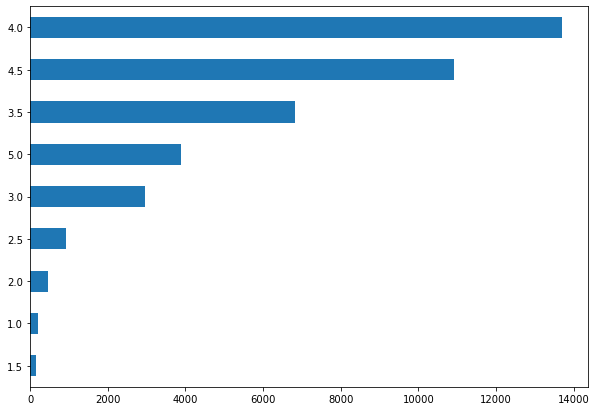

In [9]:
data['Rating'].value_counts(ascending=True).plot(kind='barh')

Посмотрим распределение целевой переменной относительно признака

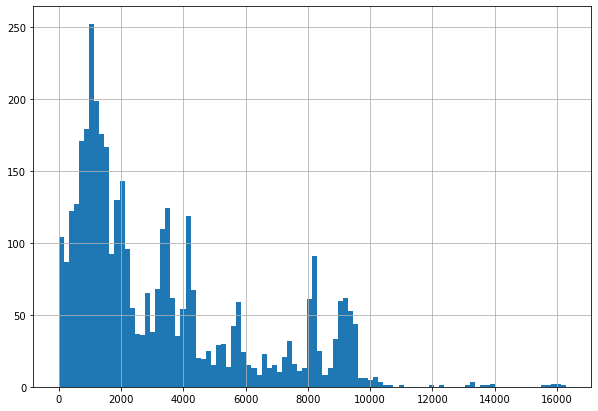

In [10]:
data['Ranking'][data['Rating'] == 5].hist(bins=100)

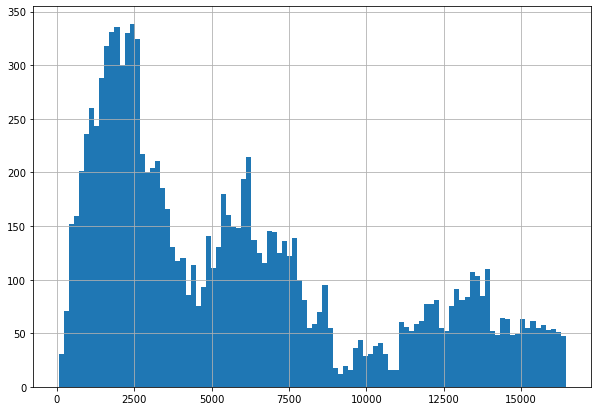

In [11]:
data['Ranking'][data['Rating'] < 4].hist(bins=100)

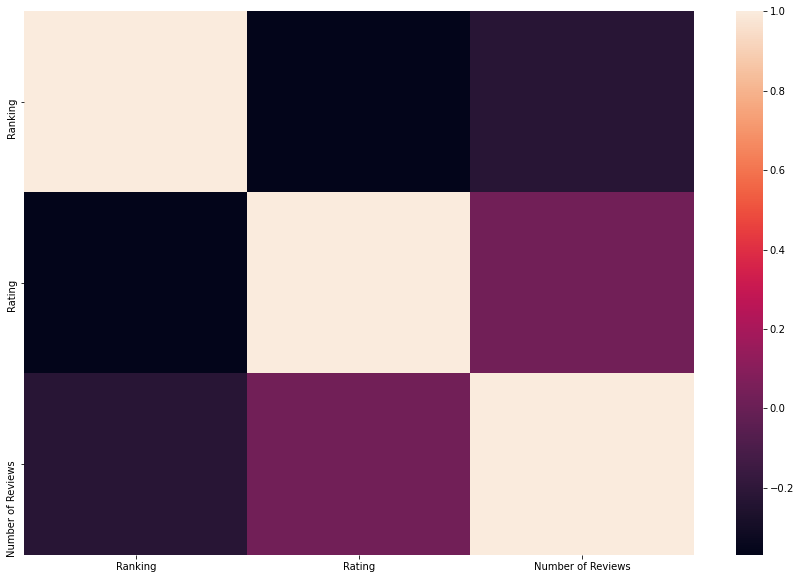

In [13]:
# Посмотрим корреляцию принаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(),)

Сначала я провел скрапинг недостающих данных (датасеты в папке 'ta-scarping'), но по какой-то причине их использование в модели только ухудшили ее результативность

In [14]:
# изменяем названия столбцов для более удобного их использования
data.columns = ['id', 'city', 'cuisine', 'ranking', 'rating',
                'price', 'reviews_count', 'reviews', 'url_ta', 'id_ta']

In [15]:
# исправляем название города
data.city[data.city == 'Oporto'] = 'Porto'

In [16]:
# убираем не нужные для модели признаки
data.drop(['url_ta'], axis=1, inplace=True)

In [17]:
# добавляем столбцы с указанием несуществующих значений
data['reviews_count_isNAN'] = pd.isna(data['reviews_count']).astype('uint8')
data['price_isNAN'] = pd.isna(data['price']).astype('uint8')
data['cuisine_isNAN'] = pd.isna(data['cuisine']).astype('uint8')

In [18]:
# заполянем недостающие данные 'price' самым часто используемым значением
data.price = data.price.astype(str).apply(
    lambda x: 2 if x == '$$ - $$$' else 1 if x == '$'
    else 3 if x == '$$$$' else 2 if x == 'None' else x)

In [19]:
# добавляем dummies 'cuisine'
sup_df = data.copy()
sup_df['cuisine'] = sup_df['cuisine'].astype(
    str).apply(lambda x: x.replace("[", ""))
sup_df['cuisine'] = sup_df['cuisine'].astype(
    str).apply(lambda x: x.replace("]", ""))
sup_df['cuisine'] = sup_df['cuisine'].astype(
    str).apply(lambda x: x.replace("'", ""))
sup_df['cuisine'] = sup_df['cuisine'].astype(
    str).apply(lambda x: x.split(', '))
extra = sup_df.explode('cuisine')
most_cui = []
for i in extra.cuisine.value_counts()[0:30].index:
    most_cui.append(i)
most_cui.append('Other')
other_cui = []
for i in extra.cuisine.value_counts()[30:].index:
    other_cui.append(i)
cui_df = pd.DataFrame(columns=most_cui)
cui_df = pd.concat([data.cuisine, cui_df], axis=1)
for i in cui_df.columns:
    cui_df[i] = cui_df.cuisine.astype(str)
for i in cui_df.columns[1:-1]:
    cui_df[i] = cui_df[i].apply(lambda x: 1 if i in x else 0)
for n in other_cui:
    cui_df['Other'] = cui_df['Other'].astype(
        str).apply(lambda x: '1' if n in x else x)
cui_df['Other'] = cui_df['Other'].apply(lambda x: 1 if x == '1' else 0)
cui_df = cui_df.drop(['cuisine'], axis=1)
cui_df = cui_df.rename(columns=lambda x: 'cs_'+x)
data = pd.concat([data, cui_df], axis=1)
# добавим признак количества кухонь в ресторане
data['cuisine_count'] = data['cuisine'].astype(str).apply(
    lambda x: x.split(', ')).apply(lambda x: len(x))

In [20]:
# добавляем dummies 'city'
data = pd.concat([data, pd.get_dummies(
    data['city'], prefix='city')], axis=1)

In [26]:
# работает с количеством отзывов
data.reviews_count = data.reviews_count.astype(
    str).apply(lambda x: 0 if x == 'nan' else x)
data.reviews_count = data.reviews_count.astype(float)
number_of_reviews_mean = data.groupby('city')['reviews_count'].mean()
data['reviews_count'] = data.apply(
    lambda row: number_of_reviews_mean[row['city']] if
    row['reviews_count'] == 0 else row['reviews_count'], axis=1)
# можно предположить, что id_ta имеет отношение к времени регистрации ресторана на TA,
# соответственно можно считать, что это ординальный признак,
# также он имеет отношение к количеству комментариев
data['id_ta'] = data['id_ta'].astype(str).apply(lambda x: x[1:])
data['id_ta'] = data['id_ta'].apply(lambda x: float(x))
# свяжем количество отзывов и новизну создания странички ресторана на ТА
data['rev_count_per_id'] = data.reviews_count * data.id_ta

In [27]:
# на основе 'city' сохданим новые признаки: является ли город столицей, его популцию и страну
data['country'] = data.city.apply(lambda x: cities.loc[x].Country)
data['population'] = data.city.apply(
    lambda x: cities.loc[x].Population)
capital_list = []
for i in capitals.capital:
    capital_list.append(i)
data['capital'] = data.city.apply(
    lambda x: 1 if x in capital_list else 0)

In [28]:
# добавим новые данные: индекс качества жизни и индекс покупательных способностей
data['life_index']=data['country'].apply(
    lambda x: life.loc[x]['Quality of life index'])
data.life_index = data.life_index.astype(float)
data['purchase_index']=data['country'].apply(
    lambda x: life.loc[x]['The index of purchasing power'])
data.purchase_index = data.purchase_index.astype(float)

In [29]:
# вычисляем к-во ресторанов для города в каждой строке и количество ресторанов в городе
res_count_per_city = data.groupby('city')['ranking'].count().to_dict()
data['rests_in_city'] = data['city'].map(res_count_per_city)
data['ranking_per_city'] = data['ranking'] / data['rests_in_city']
# добавим среднее коичество людей на 1 ресторан в городе
data['pop_per_rest'] = data['population'] / data['rests_in_city']
# частота отзывов с учетом популяции
data['rev_count_pop'] = data['reviews_count'] / data['population']
# ранг по городам, с учетом их популяции
data['ranking_per_pop'] = data['ranking_per_city'] * data['rev_count_pop']

In [30]:
# созданем новые признаки: даты указанных комментариев и их разница
temp_df = data.reviews.str.split('],', expand=True)
data['review_text'] = temp_df[0]
data['review_date'] = temp_df[1]
data.review_text = data.review_text.astype(
    str).apply(lambda x: x.replace("[", ""))
data.review_date = data.review_date.astype(
    str).apply(lambda x: x.replace("[", ""))
data.review_date = data.review_date.astype(
    str).apply(lambda x: x.replace("]", ""))
temp_df = data.review_date.str.split(', ', expand=True)
data['first_rev_date'] = temp_df[0]
data['second_rev_date'] = temp_df[1]
data['first_rev_date'] = data['first_rev_date'].apply(
    lambda x: x.replace("'", ""))
data['first_rev_date'] = data['first_rev_date'].apply(
    lambda x: x.replace(" ", ""))
data['first_rev_date'] = data['first_rev_date'].apply(
    lambda x: x.replace("ju...", ""))
data['first_rev_date'][data['first_rev_date'] == ''] = None
data['first_rev_date'][data['first_rev_date'] == 'nan'] = None
data['first_rev_date_isNAN'] = pd.isna(
    data['first_rev_date']).astype('uint8')
data['second_rev_date_isNAN'] = pd.isna(
    data['second_rev_date']).astype('uint8')
data.second_rev_date = data.second_rev_date.apply(
    lambda x: datetime.strptime(x, "'%m/%d/%Y'").timestamp() if x != None else 0.0)
data.first_rev_date = data.first_rev_date.apply(
    lambda x: datetime.strptime(x, '%m/%d/%Y').timestamp() if x != None else 0.0)
data['delta'] = data.first_rev_date - data.second_rev_date

In [31]:
# созданем новые признаки: имеет или не имеет 1 и 2 комментарий слова положительной и отрицательной окраски
temp_df = data.review_text.str.split(', ', expand=True)
data['first_review'] = temp_df[0]
data['first_review'] = data['first_review'].apply(
    lambda x: x.replace("'", "") if x != None else x)
data['second_review'] = temp_df[1]
data['second_review'] = data['second_review'].apply(
    lambda x: x.replace("'", "") if x != None else x)
g_list = []
for i in g_words[0]:
    g_list.append(i)
b_list = []
for i in b_words[0]:
    b_list.append(i)
data['first_rev_cons'] = data.first_review.astype(
    str).apply(lambda x: x.lower())
data['second_rev_cons'] = data.second_review.astype(
    str).apply(lambda x: x.lower())
data['first_rev_pros'] = data.first_review.astype(
    str).apply(lambda x: x.lower())
data['second_rev_pros'] = data.second_review.astype(
    str).apply(lambda x: x.lower())
for b in b_list:
    data['first_rev_cons'][data['first_rev_cons'].str.contains(
        b.lower(), na=False)] = '0'
    data['second_rev_cons'][data['second_rev_cons'].str.contains(
        b.lower(), na=False)] = '0'
data['first_rev_cons'] = data['first_rev_cons'].apply(
    lambda x: '1' if x != '0' else x)
data['second_rev_cons'] = data['second_rev_cons'].apply(
    lambda x: '1' if x != '0' else x)
for g in g_list:
    data['first_rev_pros'][data['first_rev_pros'].str.contains(
        g.lower(), na=False)] = '1'
    data['second_rev_pros'][data['second_rev_pros'].str.contains(
        g.lower(), na=False)] = '1'
data['first_rev_pros'] = data['first_rev_pros'].apply(
    lambda x: '0' if x != '1' else x)
data['second_rev_pros'] = data['second_rev_pros'].apply(
    lambda x: '0' if x != '1' else x)
data['first_rev_cons'] = data['first_rev_cons'].apply(lambda x: int(x))
data['second_rev_cons'] = data['second_rev_cons'].apply(lambda x: int(x))
data['first_rev_pros'] = data['first_rev_pros'].apply(lambda x: int(x))
data['second_rev_pros'] = data['second_rev_pros'].apply(lambda x: int(x))

In [32]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 0 to 39999
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ranking                 40000 non-null  float64
 1   rating                  40000 non-null  float64
 2   reviews_count           40000 non-null  float64
 3   id_ta                   40000 non-null  float64
 4   reviews_count_isNAN     40000 non-null  uint8  
 5   price_isNAN             40000 non-null  uint8  
 6   cuisine_isNAN           40000 non-null  uint8  
 7   cs_Vegetarian Friendly  40000 non-null  int64  
 8   cs_European             40000 non-null  int64  
 9   cs_nan                  40000 non-null  int64  
 10  cs_Mediterranean        40000 non-null  int64  
 11  cs_Italian              40000 non-null  int64  
 12  cs_Vegan Options        40000 non-null  int64  
 13  cs_Gluten Free Options  40000 non-null  int64  
 14  cs_Bar                  40000 non-null  int

# Включаем модель

In [33]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data.drop(['rating'], axis = 1)
y = data['rating']

In [34]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [35]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [36]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [37]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20099299999999998


In [ ]:
#функции для скрапинга недостающих значений
def get_cui(url):
    r = requests.get(url)
    content = r.content.decode('utf-8')
    soup = BeautifulSoup(content, 'html.parser')
    return soup.find('div', id="taplc_enable_cpm_desktop_0")


def get_cuisine(url):
    cu_list = []
    for i in str(get_cui(url)).rpartition('"cuisine":[')[2].rpartition('],"kw":["')[0].split():
        for n in cuisine_list:
            if n in i:
                cu_list.append(n)
    return cu_list


def get_pri(url):
    r = requests.get(url)
    content = r.content.decode('utf-8')
    BeautifulSoup(content, 'html.parser')
    return soup.find('script', type="application/ld+json")


def get_price(url):
    cu_list = []
    for i in str(get_pri(url)).replace(" ", "").split():
        for n in price_list:
            if n in i:
                cu_list.append(n)
    return cu_list


def get_rev(url):
    r = requests.get(url)
    content = r.content.decode('utf-8')
    soup = BeautifulSoup(content, 'html.parser')
    return soup.find('script', type="application/ld+json")


def get_review(url):
    return str(get_rev(url)).rpartition('"reviewCount":"')[2].rpartition('"},"address"')[0]

#a = df.url_ta[df.price.astype(str) == 'nan'].apply(lambda x: get_price(x))
# a.to_csv('review_nums')
#b = df.url_ta[df.review_num.astype(str) == 'nan'].apply(lambda x: get_review(x))
# b.to_csv('review_nums')
#c = df.url_ta[df.cuisine.astype(str) == 'nan'].apply(lambda x: get_cuisine(x))
# c.to_csv('cuisines_best')